# Data loading and inspection 

In [117]:
#Importing the necessary libraries
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import FreqDist

#modelling libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

#imbalance libraries 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lyster\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lyster\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lyster\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [118]:

# Import necessary classes from the init module
from __init__ import Explore, Clean

In [119]:
#load the data and print first five rows to ensure it loaded correctly
data = pd.read_csv('data.csv', encoding='ISO-8859-1')
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [120]:
#create instance of explore class
explore_df = Explore(data)

In [121]:
# Check the shape of the data
explore_df.shape()

----------------Shape of the Dataset---------------- 

(9093, 3)


In [122]:
#Check the columns of the data
explore_df.features()

----------------Features in the Dataset---------------- 

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')


In [123]:
#Check the summary statistics of the data
explore_df.stats()

----------------Summary Statistics of the Features---------------- 

                                               tweet_text  \
count                                                9092   
unique                                               9065   
top     RT @mention Marissa Mayer: Google Will Connect...   
freq                                                    5   

       emotion_in_tweet_is_directed_at  \
count                             3291   
unique                               9   
top                               iPad   
freq                               946   

       is_there_an_emotion_directed_at_a_brand_or_product  
count                                                9093  
unique                                                  4  
top                    No emotion toward brand or product  
freq                                                 5389  


In [124]:
#Check the basic information of the data
explore_df.info()

----------------Dataset Overall Information---------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None


In [125]:
#Renaming the columns
def rename_columns(df):
    df.columns=['tweet_text',  'recipient', 'emotion']
    return df
data = rename_columns(data)
data.head()

,tweet_text,recipient,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [126]:
# Initialize the cleaning class and call the method for displaying missing values
clean_df = Clean(data)
clean_df.missing_duplicated()



 Duplicated Rows:

- Total duplicated rows: 22 
 



,Missing Values,Percentage(%)
recipient,5802,63.807324
tweet_text,1,0.010997
emotion,0,0.000000


In [127]:
# Drop the missing record in the tweet_text column
data = data.dropna(subset=['tweet_text'])
#Check to ensure the missing record is dropped
data.isnull().sum()

tweet_text       0
recipient     5801
emotion          0
dtype: int64

In [128]:
# Fill missing values in the 'recipient' column with 'No brand'
data['recipient'].fillna('No brand', inplace=True)

C:\Users\Lyster\AppData\Local\Temp\ipykernel_3364\2107247772.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['recipient'].fillna('No brand', inplace=True)


In [129]:
#Drop the duplicate rows
clean_df.remove_duplicated_rows()

'The dataset now has 0 duplicate rows'



We'll clean and standardize the `emotion` column by simplifying the labels. Specifically, we will:

* Convert `'Positive Emotion'` to `'Positive'`
* Convert `'Negative Emotion'` to `'Negative'`
* Group both `'No emotion toward brand or product'` and `'I can't tell'` under `'Neutral'`

This transformation ensures a more consistent and streamlined set of sentiment categories, making the data better suited for sentiment analysis and model training.


In [130]:

# Change emotions to 'Positive', 'Negative', and 'Neutral'
data.loc[data['emotion'] == 'No emotion toward brand or product', 'emotion'] = 'Neutral'
data.loc[data['emotion'] == 'Positive emotion', 'emotion'] = 'Positive'
data.loc[data['emotion'] == 'Negative emotion', 'emotion'] = 'Negative'
data.loc[data['emotion'] == "I can't tell", 'emotion'] = 'Neutral'

data.head()

C:\Users\Lyster\AppData\Local\Temp\ipykernel_3364\2451357721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['emotion'] == 'No emotion toward brand or product', 'emotion'] = 'Neutral'
C:\Users\Lyster\AppData\Local\Temp\ipykernel_3364\2451357721.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['emotion'] == 'Positive emotion', 'emotion'] = 'Positive'
C:\Users\Lyster\AppData\Local\Temp\ipykernel_3364\2451357721.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,tweet_text,recipient,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive


### Feature engineering 

In this section, we create a new column called brand by mapping the values in the recipient column to either 'Apple', 'Google', or 'none', depending on the product or service mentioned. This mapping helps consolidate multiple product references under a single parent brand, making brand-level analysis clearer and more manageable. After creating the brand column, we use value_counts() to inspect the distribution of tweets across the different brands.

In [131]:
data['brand'] = data['recipient'].map({'Other Apple product or service': 'Apple', 
                                           'Android': 'Google',
                                           'Android App': 'Google',
                                           'Other Google product or service ': 'Google',
                                           'iPhone': 'Apple', 
                                           'Google':'Google',
                                           'iPad or iPhone App': 'Apple',
                                           'Apple':'Apple',
                                           'iPad':'Apple',
                                           'No brand': 'none'})

data['brand'].value_counts()

C:\Users\Lyster\AppData\Local\Temp\ipykernel_3364\2519186113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['brand'] = data['recipient'].map({'Other Apple product or service': 'Apple',


brand
none      5801
Apple     2409
Google     589
Name: count, dtype: int64

# Exploratory data analysis (EDA)

#### Univariate analysis

This section performs univariate analysis to explore the distribution of key variables individually. We examine the sentiment distribution, tweet share by brand, and tweet length to understand overall patterns in the data, detect class imbalance, and observe user engagement through tweet lengths.

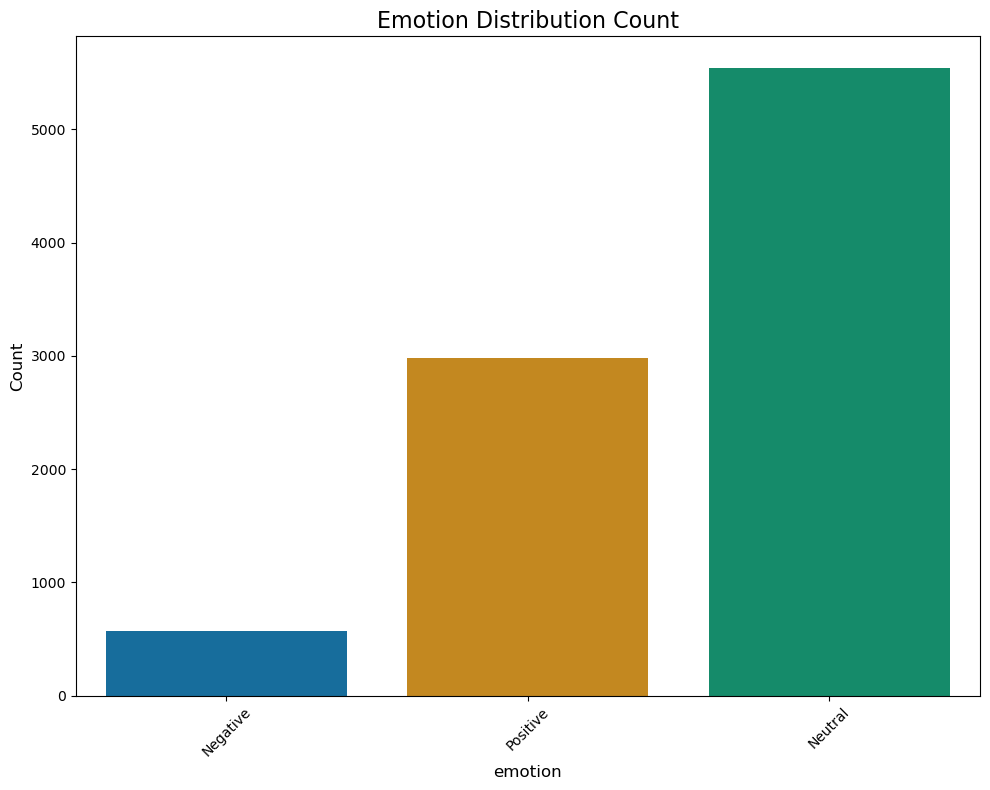

emotion
Neutral     60.976683
Positive    32.754070
Negative     6.269248
Name: proportion, dtype: float64


In [197]:

#Count plot of the 'emotion' column
plt.figure(figsize=(10, 8))
sns.countplot(x='emotion', data=data, palette='colorblind')
plt.title('Emotion Distribution Count', fontsize=16)
plt.xlabel('emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

#checking the distribution of sentiments
percentage = data['emotion'].value_counts(normalize=True)
print(percentage * 100)


brand
none      65.927946
Apple     27.378111
Google     6.693942
Name: proportion, dtype: float64


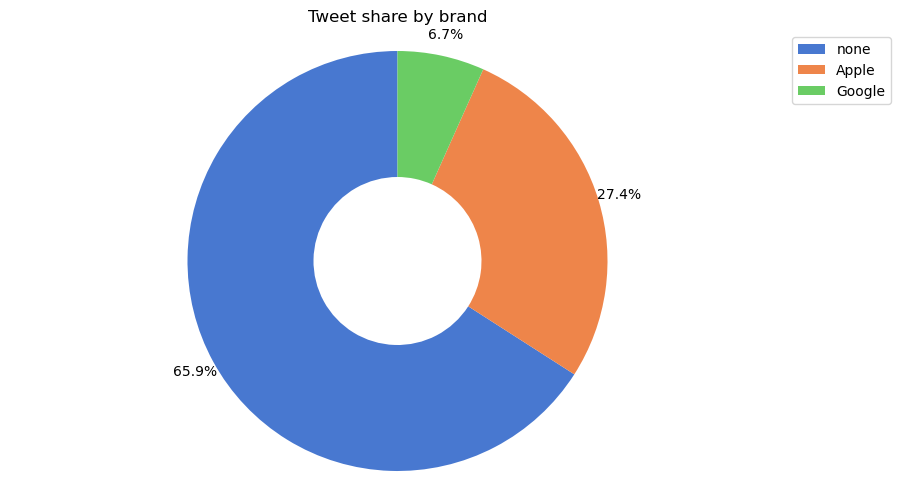

In [133]:
#pie chart to visualize Tweet share by brand
brand_share = data['brand'].value_counts(normalize=True)
print(brand_share * 100)

#Visualizing using pie chart
plt.figure(figsize=(10, 6))
plt.pie(brand_share.values, autopct='%1.1f%%', pctdistance=1.1, startangle=90, colors=sns.color_palette('muted'), wedgeprops={'width': 0.6})
plt.title('Tweet share by brand')
plt.axis('equal')
plt.legend(labels=brand_share.index, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


From the pie chart, we observe that the majority of tweets (approximately 66%) are not directed toward any specific brand, indicating a large portion of neutral or brand-unspecified discussions. Apple-related tweets make up around 27%, while Google-related tweets account for only about 7%, suggesting that Apple generates significantly more user engagement on Twitter compared to Google in this dataset.

C:\Users\Lyster\AppData\Local\Temp\ipykernel_3364\40650347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tweet_length'] = data['tweet_text'].apply(lambda x: len(str(x).split()))


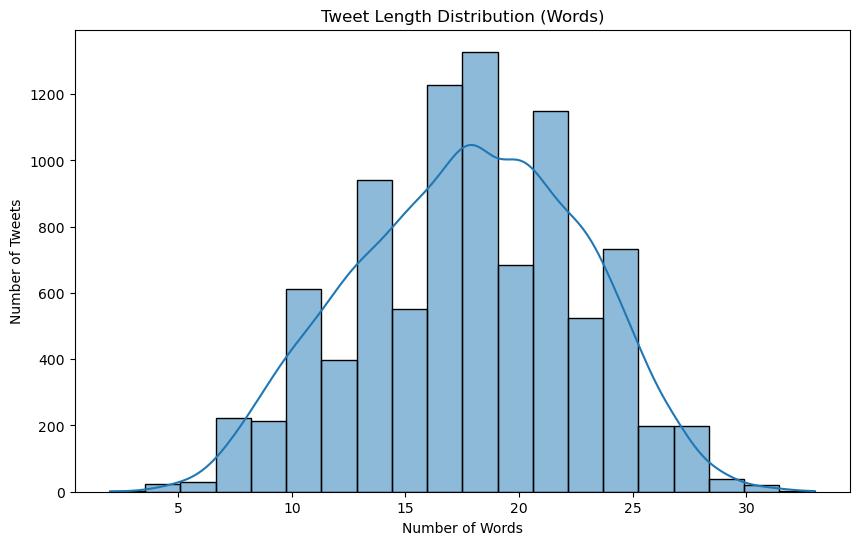

In [134]:
# Count number of words in each tweet (not characters)
data['tweet_length'] = data['tweet_text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
sns.histplot(data['tweet_length'], bins=20, kde=True)
plt.title('Tweet Length Distribution (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Number of Tweets')
plt.show()

### Bivariate analysis

In the bivariate analysis section, we explore relationships between two variables. First, we use a boxplot to examine how tweet length varies across different emotions, helping us identify whether emotional tweets tend to be longer or shorter. Next, a stacked bar chart which shows how tweet sentiments (positive, negative, neutral) are distributed across different brands, giving insight into which brand receives more emotional engagement and the nature of that sentiment.

**#### Tweet Length vs Emotion**

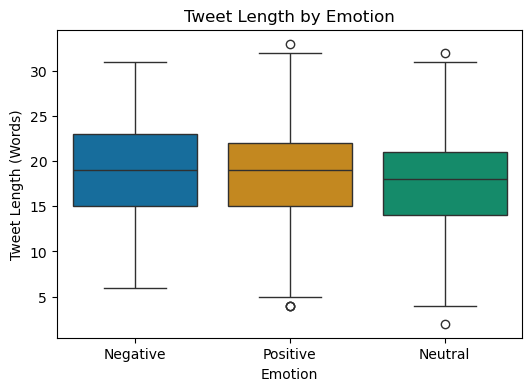

In [199]:
plt.figure(figsize=(6,4))
sns.boxplot(data=data, x='emotion', y='tweet_length', palette='colorblind')
plt.title('Tweet Length by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Tweet Length (Words)')
plt.show()


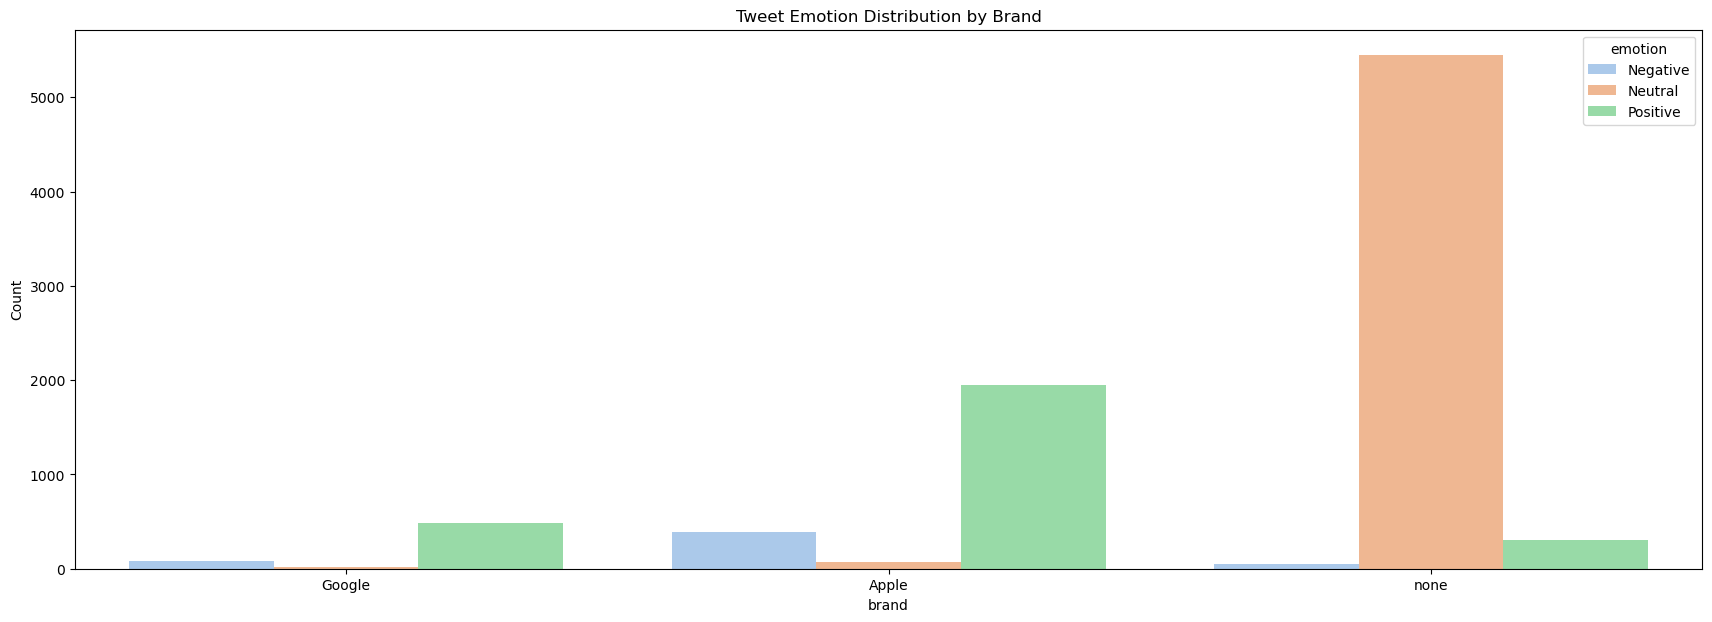

In [136]:

#Which brand is getting more positive or negative tweets?
brands = data.groupby(['brand','emotion']).size().reset_index(name='count')

#Calculate the ascending order of brands based on tweet count
ascending_order = brands.groupby('brand')['count'].sum().sort_values().index

plt.figure(figsize=(21,7))
sns.barplot(x='brand', y='count', hue='emotion', data=brands, palette='pastel', order=ascending_order)
plt.xlabel('brand')
plt.ylabel('Count')
plt.title('Tweet Emotion Distribution by Brand')
plt.show()

**#### Brand vs Emotion**

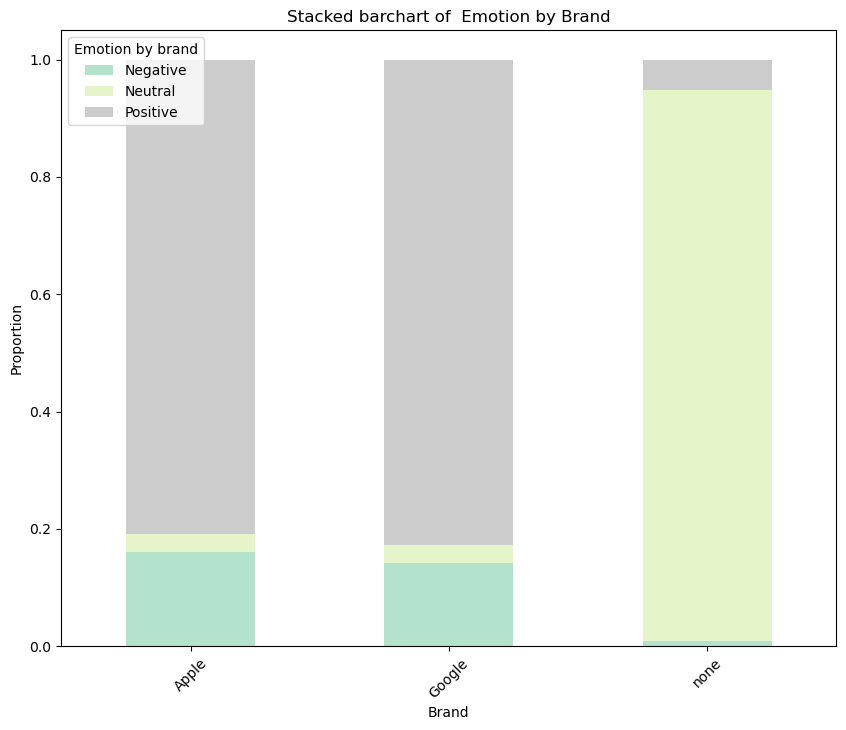

In [ ]:

brand_vs_emotion = pd.crosstab(data['brand'], data['emotion'], normalize='index')
brand_vs_emotion.plot(kind='bar', stacked=True, colormap='Pastel2', figsize=(10,8))
plt.title("Stacked barchart of  Emotion by Brand")
plt.ylabel("Proportion")
plt.xlabel("Brand")
plt.legend(title='Emotion by brand')
plt.xticks(rotation=45)
plt.show()

## Data Preprocessing

This section defines a TextPreprocessor class that performs comprehensive text preprocessing. It includes feature generation (character, word, and sentence counts), cleaning (removing URLs, emojis, punctuation, etc.), tokenization (splitting text into words), stopword removal, and lemmatization (reducing words to their base forms). The processed results are stored in new columns such as cleaned_text, tokenized_text, lemmatized_text, and document for further analysis or modeling.

In [137]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def generate_text_features(self, df, text_column):
        """
        Adds character count, word count, and sentence count columns.
        """
        df.loc[:, 'char_count'] = df[text_column].astype(str).apply(len)
        df.loc[:, 'word_count'] = df[text_column].astype(str).apply(lambda x: len(x.split()))
        df.loc[:, 'sentence_count'] = df[text_column].astype(str).apply(lambda x: x.count('.') + 1)
        return df

    def clean_text(self, text):
        """
        Cleans text: lowercase, remove URLs, hashtags, emojis, punctuation, numbers, and extra spaces.
        """
        text = text.lower()
        text = re.sub(r"http\S+|www\S+|https\S+", '', text)
        text = re.sub(r"#\w+", '', text)

        # Remove emojis
        emoji_pattern = re.compile(
            "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags
            u"\U00002700-\U000027BF"  # Dingbats
            u"\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE
        )
        text = emoji_pattern.sub(r'', text)

        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def tokenize(self, text):
        """
        Tokenizes and removes stopwords.
        """
        tokens = word_tokenize(text)
        return [t for t in tokens if t not in self.stop_words]

    def lemmatize(self, tokens):
        """
        Lemmatizes a list of tokens.
        """
        return [self.lemmatizer.lemmatize(t) for t in tokens]

    def preprocess(self, df, text_column):
        """
        Full preprocessing:
        - Feature engineering
        - Text cleaning
        - Tokenization
        - Lemmatization
        - Save cleaned text, tokens, lemmatized tokens, and document string (from tokens)
        """
        df = df.copy()  # Avoid SettingWithCopyWarning

        df = self.generate_text_features(df, text_column)
        df.loc[:, 'cleaned_text'] = df[text_column].astype(str).apply(self.clean_text)
        df.loc[:, 'tokenized_text'] = df['cleaned_text'].apply(self.tokenize)
        df.loc[:, 'lemmatized_text'] = df['tokenized_text'].apply(self.lemmatize)
        df.loc[:, 'document'] = df['tokenized_text'].apply(lambda x: ' '.join(x))

        return df

In [ ]:
# Instantiate the TextPreprocessor and preprocess the data
preprocessor = TextPreprocessor()
data = preprocessor.preprocess(data, 'tweet_text')

In [ ]:
data.head()

,tweet_text,recipient,emotion,brand,tweet_length,char_count,word_count,sentence_count,cleaned_text,tokenized_text,lemmatized_text,document
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,23,127,23,5,wesley i have a g iphone after hrs tweeting at...,"[wesley, g, iphone, hrs, tweeting, dead, need,...","[wesley, g, iphone, hr, tweeting, dead, need, ...",wesley g iphone hrs tweeting dead need upgrade...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,22,139,22,2,jessedee know about fludapp awesome ipadiphone...,"[jessedee, know, fludapp, awesome, ipadiphone,...","[jessedee, know, fludapp, awesome, ipadiphone,...",jessedee know fludapp awesome ipadiphone app y...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,15,79,15,3,swonderlin can not wait for also they should s...,"[swonderlin, wait, also, sale]","[swonderlin, wait, also, sale]",swonderlin wait also sale


#### Binary Classification

In this section, the dataset is prepared for modeling in two steps. First, the data is split into training and testing sets using the train_test_split function to ensure that model evaluation is done on unseen data. Then, the text data is converted into numerical format using CountVectorizer, which transforms the raw documents into a matrix of token counts — fitting on the training set and transforming both train and test sets accordingly.

In [ ]:
# Encode the 'emotion' column to numerical values
le = LabelEncoder()

data['emotion_code'] = le.fit_transform(data['emotion'])

In [ ]:
# Viewing the encoded 'emotion' column and the original 'emotion' column
data[['emotion', 'emotion_code']]

,emotion,emotion_code
0,Negative,0
1,Positive,2
2,Positive,2
3,Negative,0
4,Positive,2
...,...,...
9088,Positive,2
9089,Neutral,1
9090,Neutral,1
9091,Neutral,1


In [ ]:
#Make a copy of the data for binary classification
binary_data = data.copy()
binary_data.head(10)

,tweet_text,recipient,emotion,brand,tweet_length,char_count,word_count,sentence_count,cleaned_text,tokenized_text,lemmatized_text,document,emotion_code
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,23,127,23,5,wesley i have a g iphone after hrs tweeting at...,"[wesley, g, iphone, hrs, tweeting, dead, need,...","[wesley, g, iphone, hr, tweeting, dead, need, ...",wesley g iphone hrs tweeting dead need upgrade...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,22,139,22,2,jessedee know about fludapp awesome ipadiphone...,"[jessedee, know, fludapp, awesome, ipadiphone,...","[jessedee, know, fludapp, awesome, ipadiphone,...",jessedee know fludapp awesome ipadiphone app y...,2
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,15,79,15,3,swonderlin can not wait for also they should s...,"[swonderlin, wait, also, sale]","[swonderlin, wait, also, sale]",swonderlin wait also sale,2
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,15,82,15,2,sxsw i hope this years festival isnt as crashy...,"[sxsw, hope, years, festival, isnt, crashy, ye...","[sxsw, hope, year, festival, isnt, crashy, yea...",sxsw hope years festival isnt crashy years iph...,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,17,131,17,1,sxtxstate great stuff on fri marissa mayer goo...,"[sxtxstate, great, stuff, fri, marissa, mayer,...","[sxtxstate, great, stuff, fri, marissa, mayer,...",sxtxstate great stuff fri marissa mayer google...,2
5,@teachntech00 New iPad Apps For #SpeechTherapy...,No brand,Neutral,none,18,140,18,2,teachntech new ipad apps for and communication...,"[teachntech, new, ipad, apps, communication, s...","[teachntech, new, ipad, apps, communication, s...",teachntech new ipad apps communication showcas...,1
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive,Google,28,138,28,1,is just starting is around the corner and is o...,"[starting, around, corner, hop, skip, jump, go...","[starting, around, corner, hop, skip, jump, go...",starting around corner hop skip jump good time...,2
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive,Apple,17,129,17,2,beautifully smart and simple idea rt madebyman...,"[beautifully, smart, simple, idea, rt, madebym...","[beautifully, smart, simple, idea, rt, madebym...",beautifully smart simple idea rt madebymany th...,2
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive,Apple,16,88,16,1,counting down the days to plus strong canadian...,"[counting, days, plus, strong, canadian, dolla...","[counting, day, plus, strong, canadian, dollar...",counting days plus strong canadian dollar mean...,2
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive,Google,21,118,21,3,excited to meet the samsungmobileus at so i ca...,"[excited, meet, samsungmobileus, show, sprint,...","[excited, meet, samsungmobileus, show, sprint,...",excited meet samsungmobileus show sprint galax...,2


In [ ]:
#Dropping the records with 'emotion_code' == 1 (which corresponds to 'Neutral emotion')
binary_data.drop(binary_data[binary_data['emotion_code'] == 1].index, inplace=True)
binary_data.head()

,tweet_text,recipient,emotion,brand,tweet_length,char_count,word_count,sentence_count,cleaned_text,tokenized_text,lemmatized_text,document,emotion_code
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,23,127,23,5,wesley i have a g iphone after hrs tweeting at...,"[wesley, g, iphone, hrs, tweeting, dead, need,...","[wesley, g, iphone, hr, tweeting, dead, need, ...",wesley g iphone hrs tweeting dead need upgrade...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,22,139,22,2,jessedee know about fludapp awesome ipadiphone...,"[jessedee, know, fludapp, awesome, ipadiphone,...","[jessedee, know, fludapp, awesome, ipadiphone,...",jessedee know fludapp awesome ipadiphone app y...,2
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,15,79,15,3,swonderlin can not wait for also they should s...,"[swonderlin, wait, also, sale]","[swonderlin, wait, also, sale]",swonderlin wait also sale,2
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,15,82,15,2,sxsw i hope this years festival isnt as crashy...,"[sxsw, hope, years, festival, isnt, crashy, ye...","[sxsw, hope, year, festival, isnt, crashy, yea...",sxsw hope years festival isnt crashy years iph...,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,17,131,17,1,sxtxstate great stuff on fri marissa mayer goo...,"[sxtxstate, great, stuff, fri, marissa, mayer,...","[sxtxstate, great, stuff, fri, marissa, mayer,...",sxtxstate great stuff fri marissa mayer google...,2
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive,Google,28,138,28,1,is just starting is around the corner and is o...,"[starting, around, corner, hop, skip, jump, go...","[starting, around, corner, hop, skip, jump, go...",starting around corner hop skip jump good time...,2
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive,Apple,17,129,17,2,beautifully smart and simple idea rt madebyman...,"[beautifully, smart, simple, idea, rt, madebym...","[beautifully, smart, simple, idea, rt, madebym...",beautifully smart simple idea rt madebymany th...,2
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive,Apple,16,88,16,1,counting down the days to plus strong canadian...,"[counting, days, plus, strong, canadian, dolla...","[counting, day, plus, strong, canadian, dollar...",counting days plus strong canadian dollar mean...,2
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive,Google,21,118,21,3,excited to meet the samsungmobileus at so i ca...,"[excited, meet, samsungmobileus, show, sprint,...","[excited, meet, samsungmobileus, show, sprint,...",excited meet samsungmobileus show sprint galax...,2
11,Find &amp; Start Impromptu Parties at #SXSW Wi...,Android App,Positive,Google,19,129,19,3,find amp start impromptu parties at with hurri...,"[find, amp, start, impromptu, parties, hurrica...","[find, amp, start, impromptu, party, hurricane...",find amp start impromptu parties hurricanepart...,2


In [144]:
binary_data['emotion_code'].value_counts()

emotion_code
2    2978
0     570
Name: count, dtype: int64

In [145]:
# split data to train and test sets

X = binary_data['document']
y = binary_data['emotion_code']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [146]:
# vectorize

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

We will use the logistic regression as our baseline model

In [147]:
logreg = LogisticRegression()

logreg.fit(X_train_vec, y_train)

LogisticRegression()

In [148]:
y_pred = logreg.predict(X_test_vec)
y_train_pred = logreg.predict(X_train_vec)

print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Test accuracy:", accuracy_score(y_test, y_pred))

Train accuracy: 0.971815107102593
Test accuracy: 0.8804960541149943


In [149]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.35      0.48       137
           2       0.89      0.98      0.93       750

    accuracy                           0.88       887
   macro avg       0.82      0.66      0.70       887
weighted avg       0.87      0.88      0.86       887



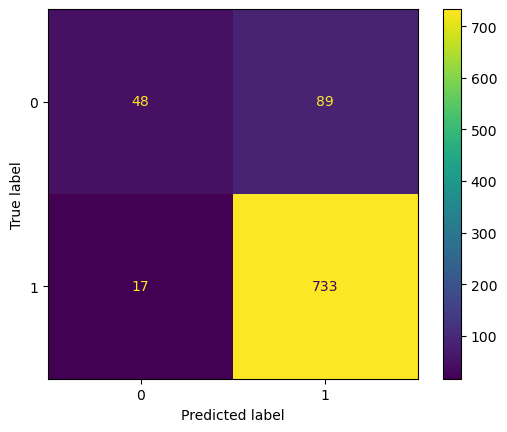

In [150]:
#plot a confusion matrix
log_matrix = confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = log_matrix)
cm_display.plot()
plt.show()

True Negatives (48): Model correctly predicted 0 when the true label was 0.

False Positives (89): Model incorrectly predicted 1 when the true label was 0.

False Negatives (17): Model incorrectly predicted 0 when the true label was 1.

True Positives (733): Model correctly predicted 1 when the true label was 1.

Summary:
The model performs very well on class 1 (positive/majority class) with high true positives and low false negatives. However, it struggles with class 0 (negative/minority class), misclassifying nearly 65% (89 out of 137) of them. This indicates class imbalance We'll try fitting a decision tree while accounting for the class imbalance to see if there will be better performance.

In [151]:
weighted_tree = DecisionTreeClassifier(class_weight='balanced', random_state=42)
weighted_tree.fit(X_train_vec, y_train)


y_train_pred = weighted_tree.predict(X_train_vec)
y_pred = weighted_tree.predict(X_test_vec)

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

Train Accuracy: 1.0
Test Accuracy: 0.7970687711386697

 Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.53      0.45       137
           2       0.91      0.85      0.88       750

    accuracy                           0.80       887
   macro avg       0.65      0.69      0.66       887
weighted avg       0.83      0.80      0.81       887



The tree performs worse than the logistic regression model. Let's try fitting again without accounting for the imbalance

In [152]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_vec, y_train)

DecisionTreeClassifier(random_state=42)

In [153]:
# Evaluation 
y_train_pred = tree.predict(X_train_vec)
y_pred = tree.predict(X_test_vec)

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

Train Accuracy: 1.0
Test Accuracy: 0.8680947012401353

 Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.36      0.46       137
           2       0.89      0.96      0.92       750

    accuracy                           0.87       887
   macro avg       0.76      0.66      0.69       887
weighted avg       0.85      0.87      0.85       887



The tree performs a bit better without accounting for class imbalance.However the accuracies are not satisfactory so we'll try tuning to reduce overfitting by tuning the model.

In [154]:
param_grid = {
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy', 'log_loss']  
}


grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)


grid_search.fit(X_train_vec, y_train)


print("Best Parameters:", grid_search.best_params_)

best_tree = grid_search.best_estimator_

y_train_pred = best_tree.predict(X_train_vec)
y_pred = best_tree.predict(X_test_vec)

print(f"\n Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"\n Test Accuracy: {accuracy_score(y_test, y_pred)}")

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}

 Train Accuracy: 0.8726042841037204

 Test Accuracy: 0.8635851183765502


c:\Users\Lyster\Documents\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.84329515 0.84404985 0.84066287 0.8079688  0.80609051 0.81999605
 0.84366968 0.84366968 0.84366968 0.84366968 0.84366968 0.84366968
 0.84705243 0.84705243 0.84742767 0.84705243 0.84705243 0.84742767
 0.85118354 0.85118354 0.85118425 0.84968049 0.84930455 0.85005643
 0.83540324 0.8342733  0.83615018 0.80909379 0.80759356 0.81510813
 0.8429178  0.8429178  0.8429178  0.8429178  0.8429178  0.8429178
 0.84667649 0.84667649 0.84705173 0.84667649 0.84667649 0.84705173
 0.84592179 0.84629773 0.84592179 0.84629844 0.84705032 0.84592179
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(


These are reasonable accuracies.So far this tuned tree and logistic regression are the best models

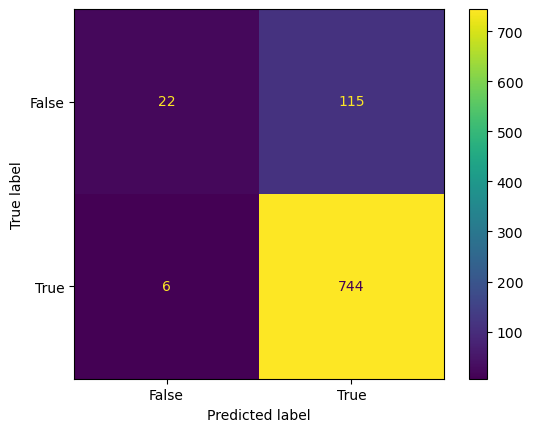

In [155]:
tree_matrix = confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = tree_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

Tuning reduces overfitting. However there are many false positives

Let's try another model

In [156]:
forest = RandomForestClassifier(random_state=42)

forest.fit(X_train_vec, y_train)

RandomForestClassifier(random_state=42)

In [157]:
y_train_pred = forest.predict(X_train_vec)
y_pred = forest.predict(X_test_vec)

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Train Accuracy: 1.0
Test Accuracy: 0.8804960541149943


The random forest is overfitting the data 

Let's try tuning it

In [158]:
param_grid = {
    'n_estimators': [50, 100],         # Number of trees
    'max_depth': [None, 5, 10],            # Depth of each tree
    'min_samples_split': [2, 5],        # Min samples to split a node
    'min_samples_leaf': [1, 2],          # Min samples at a leaf node
    'criterion': ['gini', 'entropy', 'log_loss'],        # Splitting criteria
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(
    estimator=forest,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='accuracy'
)

grid.fit(X_train_vec, y_train)

print("Best Parameters:", grid.best_params_)

best_rf = grid.best_estimator_

y_train_pred = best_rf.predict(X_train_vec)
y_pred = best_rf.predict(X_test_vec)

print(f"\n Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

c:\Users\Lyster\Documents\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.86583991 0.86696731 0.86433672 0.86396092 0.85043217 0.85118377
 0.85043217 0.85193536 0.86471251 0.86433672 0.86057873 0.85907554
 0.83727922 0.83727922 0.83727922 0.83727922 0.83727922 0.83727922
 0.83727922 0.83727922 0.83727922 0.83727922 0.83727922 0.83727922
 0.83727922 0.83727922 0.83727922 0.83727922 0.83727922 0.83727922
 0.83727922 0.83727922 0.83803082 0.83727922 0.83803082 0.83727922
 0.83803082 0.83727922 0.83803082 0.83727922 0.83727922 0.83727922
 0.83727922 0.83727922 0.83727922 0.83727922 0.83727922 0.83727922
 0.86659151 0.86546411 0.86396092 0.86283352 0.85155956 0.85268696
 0.85118377 0.85268696 0.86508831 0.86396092 0.86358512 0.86170613
 0.83727922 0.83727922 0.83727922 0.83727922 0.83727922 0.83727922
 0.83727922 0.83727922 0.83727922 0.83727922 0.83727922 0.83727922
 0.83727922 0.83727922 0.83

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

 Train Accuracy: 1.0
Test Accuracy: 0.8804960541149943


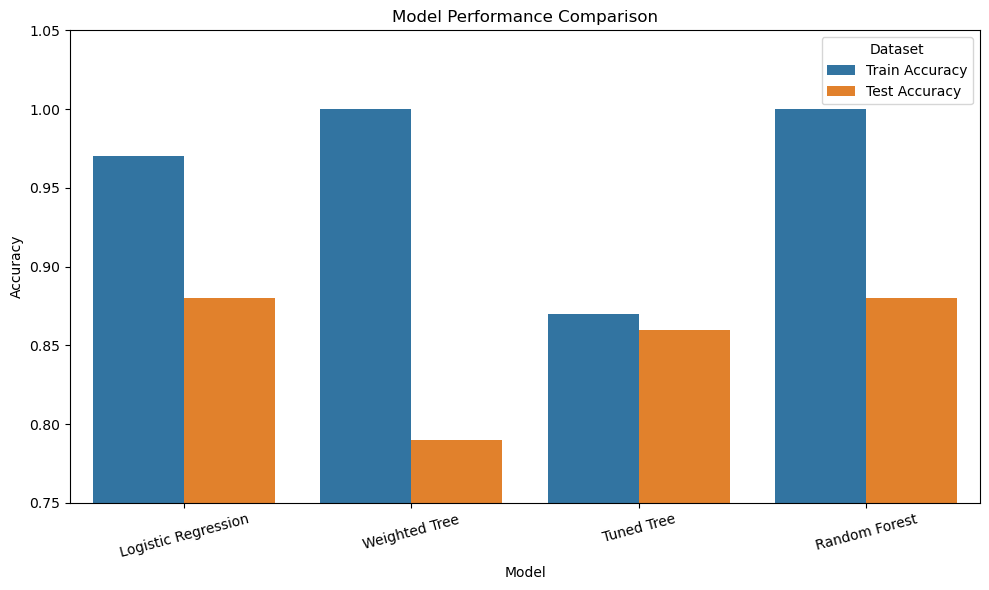

In [159]:
# Sample performance data
models = ['Logistic Regression', 'Weighted Tree', 'Tuned Tree', 'Random Forest']
train_accuracy = [0.97, 1.00, 0.87, 1.00]
test_accuracy = [0.88, 0.79, 0.86, 0.88]

# Create a DataFrame
df = pd.DataFrame({
    'Model': models,
    'Train Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy
})

# Melt the DataFrame for seaborn
df_melted = df.melt(id_vars='Model', var_name='Dataset', value_name='Accuracy')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Model', y='Accuracy', hue='Dataset')
plt.title('Model Performance Comparison')
plt.ylim(0.75, 1.05)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [160]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)

print("Resampled class distribution:", pd.Series(y_train_resampled).value_counts())

Resampled class distribution: emotion_code
2    2228
0    2228
Name: count, dtype: int64


In [161]:
logreg.fit(X_train_resampled, y_train_resampled)

y_pred = logreg.predict(X_test_vec)
y_train_pred = logreg.predict(X_train_resampled)

print("Train accuracy:", accuracy_score(y_train_resampled, y_train_pred))
print("Test accuracy:", accuracy_score(y_test, y_pred))


Train accuracy: 0.973967684021544
Test accuracy: 0.8072153325817362


In [162]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.64      0.50       137
           2       0.93      0.84      0.88       750

    accuracy                           0.81       887
   macro avg       0.67      0.74      0.69       887
weighted avg       0.85      0.81      0.82       887



After resampling the data, the logistic regression performs a bit better for the minority class

The accuracies are however worse than the first logistic regression model

Let's try our tuned tree on the resampled data

In [163]:
param_grid = {
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy', 'log_loss']  
}


grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)


grid_search.fit(X_train_resampled, y_train_resampled)


print("Best Parameters:", grid_search.best_params_)

best_tree = grid_search.best_estimator_

y_train_pred = best_tree.predict(X_train_resampled)
y_pred = best_tree.predict(X_test_vec)

print(f"\n Train Accuracy: {accuracy_score(y_train_resampled, y_train_pred)}")
print(f"\n Test Accuracy: {accuracy_score(y_test, y_pred)}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}

 Train Accuracy: 0.9755385996409336

 Test Accuracy: 0.7406989853438557

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.51      0.38       137
           2       0.90      0.78      0.84       750

    accuracy                           0.74       887
   macro avg       0.60      0.65      0.61       887
weighted avg       0.81      0.74      0.77       887



c:\Users\Lyster\Documents\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.82162557 0.8285848  0.82925795 0.81489081 0.81354401 0.81983084
 0.65194244 0.65194244 0.65194244 0.65194244 0.65194244 0.65194244
 0.69503304 0.69503304 0.69503304 0.69480857 0.69480857 0.69480857
 0.73879553 0.73902125 0.73789892 0.73632715 0.73632715 0.73610419
 0.81915644 0.8218513  0.82993135 0.80703724 0.80950512 0.81579321
 0.64251483 0.64251483 0.64251483 0.64229037 0.64229037 0.64229037
 0.68336026 0.68336026 0.68336026 0.68358473 0.68358473 0.68358473
 0.7349806  0.73475689 0.73408298 0.73273593 0.7329604  0.73385927
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(


### Multiclass classification

In this section, we will focus on multiclass classification. The dataset contains multiple classes, and we will explore how to handle this scenario effectively.We will use the Logistic regression model as our base model for multiclass classification. 

In [ ]:
#View the columns of the data
data.columns

Index(['tweet_text', 'recipient', 'emotion', 'brand', 'tweet_length',
       'char_count', 'word_count', 'sentence_count', 'cleaned_text',
       'tokenized_text', 'lemmatized_text', 'document', 'emotion_code'],
      dtype='object')

In [ ]:
#View the value counts of the 'emotion_code' column in the data dataframe
y = data['emotion_code']
y.value_counts()

emotion_code
1    5544
2    2978
0     570
Name: count, dtype: int64

We now assign the 'emotion_code' column to the variable `y` and X will be the rest of the columns in the data dataframe then vectorize it using the countvectorizer. 

In [166]:
# Assigning X and y for the model
X = data['document']  # Features
y = data['emotion_code']  # Target variable
# Vectorizing the document column
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

In [167]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)


In [180]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
logistic_model = LogisticRegression()
# Fit the model on the training data
logistic_model.fit(X_train, y_train)
# Make predictions on the testing data
y_pred_log = logistic_model.predict(X_test)
# Evaluate the model
print("Train Accuracy:", accuracy_score(y_train, logistic_model.predict(X_train)))

print("Test Accuracy:", accuracy_score(y_test, y_pred_log))

Train Accuracy: 0.9078784545579541
Test Accuracy: 0.6816932380428807


c:\Users\Lyster\Documents\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We will now use a Multinomial Naive Bayes model for multiclass classification. This model is suitable for text classification tasks and can handle multiple classes effectively.This model is suitable for text classification tasks and can handle multiple classes effectively.

In [168]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()


nb_model.fit(X_train, y_train)
y_test_pred_nb = nb_model.predict(X_test)
y_train_pred_nb = nb_model.predict(X_train)

print("Naive Bayes Results")
print(classification_report(y_train, y_train_pred_nb))
print("Accuracy:", accuracy_score(y_train, y_train_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_test_pred_nb))


Naive Bayes Results
              precision    recall  f1-score   support

           0       0.81      0.44      0.57       449
           1       0.83      0.93      0.88      4452
           2       0.82      0.72      0.77      2372

    accuracy                           0.83      7273
   macro avg       0.82      0.70      0.74      7273
weighted avg       0.83      0.83      0.82      7273

Accuracy: 0.8290939089784133
Accuracy: 0.6564046179219352


The model performs well for the training data but poorly on the test data. This is likely due to overfitting. Let's try tuning the model to see if we can improve performance.

### Tuning using GridSearchCV

In [171]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.1, 1.0, 10.0]  # no prefix needed
}

grid_nb = GridSearchCV(
    estimator=MultinomialNB(),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_nb.fit(X_train, y_train)  
best_nb_model = grid_nb.best_estimator_
y_train_pred_gridnb = best_nb_model.predict(X_train)
y_test_pred_gridnb = best_nb_model.predict(X_test)


In [170]:
#Accuracies
print('Train Accuracy :', accuracy_score(y_train, y_train_pred_gridnb))
print('Test Accuracy :', accuracy_score(y_test, y_test_pred_gridnb))
print('classification_report :', classification_report(y_test, y_test_pred_gridnb))

Train Accuracy : 0.8290939089784133
Test Accuracy : 0.6564046179219352
classification_report :               precision    recall  f1-score   support

           0       0.38      0.21      0.27       121
           1       0.72      0.78      0.75      1092
           2       0.56      0.53      0.55       606

    accuracy                           0.66      1819
   macro avg       0.55      0.50      0.52      1819
weighted avg       0.64      0.66      0.65      1819



From the classification report the model still does not perform well on the test data. This is likely due to the class imbalance in the dataset. We can try using a model that can handle class imbalance better, such as r an XGBoost classifier.

In [175]:
from xgboost import XGBClassifier
#Initialize the XGBoost classifier
xgb_classifier = XGBClassifier()

# Fit the model on the training data-
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [176]:
# Make predictions on the testing data and the training data

y_pred_xgb =  xgb_classifier.predict(X_test)
y_train_pred_xgb =  xgb_classifier.predict(X_train)

print('Train Accuracy:', accuracy_score(y_train, y_train_pred_xgb))
print('Test Accuracy:', accuracy_score(y_test, y_pred_xgb))
# Print classification report
print(classification_report(y_test, y_pred_xgb))

Train Accuracy: 0.7945827031486319
Test Accuracy: 0.6783947223749313
              precision    recall  f1-score   support

           0       0.58      0.12      0.20       121
           1       0.68      0.90      0.78      1092
           2       0.66      0.38      0.49       606

    accuracy                           0.68      1819
   macro avg       0.64      0.47      0.49      1819
weighted avg       0.67      0.68      0.64      1819



From the results we can see the model performs well on the training data but poorly on the test data. This is likely due to overfitting. Let's try tuning the model to see if we can improve performance.

In [189]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': range(3, 11),  # Example: 3, 5, 7, 9
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_xgb = grid_search.best_estimator_

# Evaluate
from sklearn.metrics import accuracy_score, classification_report

y_pred = best_xgb.predict(X_test)
train_accuracy = best_xgb.score(X_train, y_train)
test_accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 192 candidates, totalling 576 fits


c:\Users\Lyster\Documents\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py:158: UserWarning: [13:19:25] WARNING: D:\bld\xgboost-split_1724807710452\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1}
Train Accuracy: 0.8356936614876942
Test Accuracy: 0.679494227597581

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.15      0.23       121
           1       0.69      0.88      0.78      1092
           2       0.65      0.42      0.51       606

    accuracy                           0.68      1819
   macro avg       0.61      0.48      0.51      1819
weighted avg       0.67      0.68      0.65      1819



The tuned XGBoost classifier performs well on the training data but poorly on the test data even after tuning. We now use a Random Forest classifier to see if we can improve performance.

In [183]:
#Instantiate the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
# Fit the model on the training data
rf_classifier.fit(X_train, y_train)
# Make predictions on the testing data and the training data
y_pred_rf = rf_classifier.predict(X_test)
y_train_pred_rf = rf_classifier.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred_rf))
print('Test Accuracy:', accuracy_score(y_test, y_pred_rf))
# Print classification report
print(classification_report(y_test, y_pred_rf))


Train Accuracy: 0.9918878042073422
Test Accuracy: 0.6745464540956569
              precision    recall  f1-score   support

           0       0.61      0.17      0.26       121
           1       0.69      0.86      0.77      1092
           2       0.63      0.44      0.52       606

    accuracy                           0.67      1819
   macro avg       0.64      0.49      0.51      1819
weighted avg       0.66      0.67      0.65      1819



The models we have implemented so far are performing well on the training data but poorly on the test data. This is likely due to overfitting. Let's try oversampling the minority class to see if we can improve performance.

In [184]:
# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)

print("Original class distribution:", y_train.value_counts().to_dict())
print("Balanced class distribution:", dict(pd.Series(y_train_balanced).value_counts()))

Original class distribution: {1: 4452, 2: 2372, 0: 449}
Balanced class distribution: {2: 4452, 1: 4452, 0: 4452}


**XGBoost model with the balanced dataset:**

In [193]:
xgb_balanced = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    n_estimators=125,
    max_depth=7,
    learning_rate=0.3,
    subsample=1,
    colsample_bytree=1,
    random_state=42
)

xgb_balanced.fit(X_train_balanced, y_train_balanced)

y_pred = xgb_balanced.predict(X_test)

# Evaluation
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Test Accuracy: 0.6338647608576141
              precision    recall  f1-score   support

           0       0.28      0.42      0.34       121
           1       0.75      0.68      0.71      1092
           2       0.55      0.59      0.57       606

    accuracy                           0.63      1819
   macro avg       0.53      0.56      0.54      1819
weighted avg       0.65      0.63      0.64      1819



## Using SMOTE with XGBoost

In [187]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [188]:
# Initialize XGBoost
xgb_smote = XGBClassifier(
    objective='multi:softprob',  # Or 'multi:softmax' if you want class labels directly
    num_class=3,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=7,
    random_state=42
)

# Fit the model
xgb_smote.fit(X_train_smote, y_train_smote)

# Predict
y_test_pred_smote = xgb_smote.predict(X_test)
y_train_pred_smote = xgb_smote.predict(X_train_smote)

# Evaluate
print("Train Accuracy:", accuracy_score(y_train_smote, y_train_pred_smote))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_smote))
print(classification_report(y_test, y_pred))

Train Accuracy: 0.8565438754118
Test Accuracy: 0.6663001649257834
              precision    recall  f1-score   support

           0       0.28      0.42      0.34       121
           1       0.75      0.68      0.71      1092
           2       0.55      0.59      0.57       606

    accuracy                           0.63      1819
   macro avg       0.53      0.56      0.54      1819
weighted avg       0.65      0.63      0.64      1819



## Limitations 
The models implemented so far have not performed well on the test data. This is likely due to  class imbalance in the dataset. 
SMOTE is a technique that can help address this issue by generating synthetic samples for the minority class but the real-world performance of the model may still be limited by the quality of the data and the complexity of the problem.

The dataset is relatively small, which may limit the model's ability to generalize to unseen data.